# Playing around with the split isolation model

In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
import demesdraw
import moments
import dadi


This is to get a good idea of what the prior parameter distribution should be. 

In [29]:
# Define key parameters for the model
N1 = 1000  # Population size of population 1
N2 = 1200  # Population size of population 2
Na = 2000  # Ancestral population size
T_split = 500  # Time since split in generations
mutation_rate = 1e-8  # Mutation rate per base pair per generation
recombination_rate = 1e-8  # Recombination rate per base pair per generation

# Sample sizes
samples_pop1 = 15  # 15 samples from population 1
samples_pop2 = 8   # 8 samples from population 2

# Define the demographic history
demography = msprime.Demography()
demography.add_population(name="pop1", initial_size=N1)
demography.add_population(name="pop2", initial_size=N2)
demography.add_population(name="ancestral", initial_size=Na)
demography.add_population_split(time=T_split, derived=["pop1", "pop2"], ancestral="ancestral")

# Simulate the tree sequence with different sample sizes
ts = msprime.sim_ancestry(
    samples={"pop1": samples_pop1, "pop2": samples_pop2},
    demography=demography,
    sequence_length=1e6,  # Simulate 1 Mb of sequence
    recombination_rate=recombination_rate
)

print("Sampled populations:", ts.num_populations, ts.num_samples)

# Simulate mutations on the tree sequence
mutated_ts = msprime.sim_mutations(ts, rate=mutation_rate)

# Output some information about the simulation
print(f"Number of mutations: {mutated_ts.num_mutations}")
print(f"Number of trees: {mutated_ts.num_trees}")


Sampled populations: 3 46
Number of mutations: 346
Number of trees: 303


In [30]:
for i in range(3):
    print(ts.samples(population = i))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[]


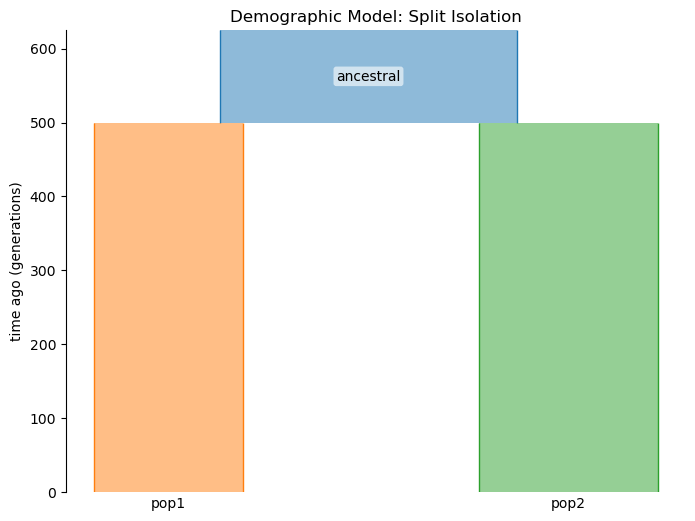

In [16]:
# Convert msprime demography to demes graph
demes_graph = demography.to_demes()

# Visualize the demographic model using demesdraw
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
demesdraw.tubes(demes_graph, ax=ax)
plt.title("Demographic Model: Split Isolation")
plt.show()

In [38]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
import demesdraw
import moments
import dadi

# Define key parameters for the model
N1 = 1000  # Population size of population 1
N2 = 1200  # Population size of population 2
Na = 2000  # Ancestral population size
T_split = 500  # Time since split in generations
mutation_rate = 1e-8  # Mutation rate per base pair per generation
recombination_rate = 1e-8  # Recombination rate per base pair per generation

# Sample sizes
samples_pop1 = 15  # 15 samples from population 1
samples_pop2 = 8   # 8 samples from population 2

# Define the demographic history
demography = msprime.Demography()
demography.add_population(name="pop1", initial_size=N1)
demography.add_population(name="pop2", initial_size=N2)
demography.add_population(name="ancestral", initial_size=Na)
demography.add_population_split(time=T_split, derived=["pop1", "pop2"], ancestral="ancestral")

# Define the samples using msprime.SampleSet
samples = [
    msprime.SampleSet(samples_pop1, population="pop1", ploidy=1),  # Population 1 samples
    msprime.SampleSet(samples_pop2, population="pop2", ploidy=1)   # Population 2 samples
]

# Simulate the tree sequence with correct sample sizes
ts = msprime.sim_ancestry(
    samples=samples,
    demography=demography,
    sequence_length=1e6,  # Simulate 1 Mb of sequence
    recombination_rate=recombination_rate,
    random_seed=42  # Optional: For reproducibility
)

# Check the samples for each population
for i in range(ts.num_populations):
    print(f"Population {i} samples:", ts.samples(population=i))

# Simulate mutations on the tree sequence
mutated_ts = msprime.sim_mutations(ts, rate=mutation_rate)

# Output information about mutations and trees in the tree sequence
print(f"Number of mutations: {mutated_ts.num_mutations}")
print(f"Number of trees: {mutated_ts.num_trees}")

Population 0 samples: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Population 1 samples: [15 16 17 18 19 20 21 22]
Population 2 samples: []
Number of mutations: 257
Number of trees: 208


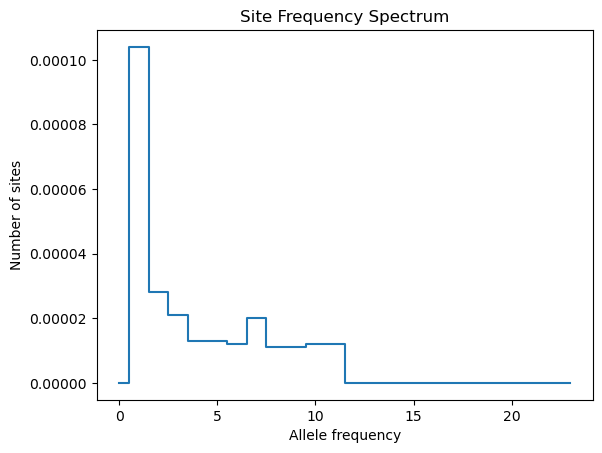

In [39]:
# Visualize the SFS (site frequency spectrum) using moments
sfs = mutated_ts.allele_frequency_spectrum(polarised=False)
plt.step(range(len(sfs)), sfs, where="mid")
plt.xlabel("Allele frequency")
plt.ylabel("Number of sites")
plt.title("Site Frequency Spectrum")
plt.show()

2D Joint SFS shape: (16, 9)


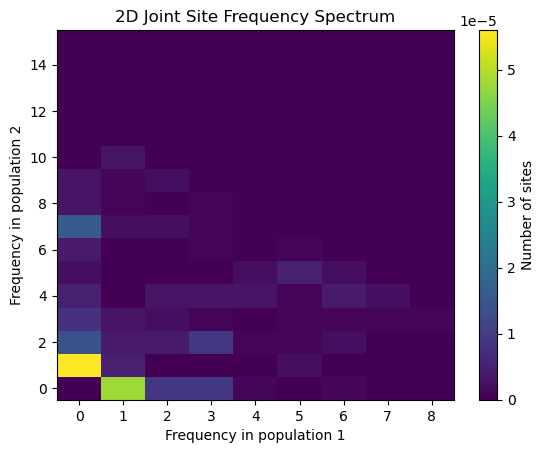

In [41]:
# Define sample sets for calculating the joint 2D SFS
sample_sets = [
    ts.samples(population=0),  # Population 1
    ts.samples(population=1)   # Population 2
]

# Compute the 2D joint SFS
sfs = mutated_ts.allele_frequency_spectrum(sample_sets=sample_sets, polarised=False)

# Output the 2D joint SFS
print("2D Joint SFS shape:", sfs.shape)

# Visualize the 2D joint SFS
plt.imshow(sfs, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="Number of sites")
plt.xlabel("Frequency in population 1")
plt.ylabel("Frequency in population 2")
plt.title("2D Joint Site Frequency Spectrum")
plt.show()

In [2]:
upper_bound_params = {
    "t_split": 5000, 
    "N1": 10000,
    "N2": 10000,
    "Na": 20000
}

lower_bound_params =  {
    "t_split": 100, 
    "N1": 100,
    "N2": 100,
    "Na": 100

}

mutation_rate = 5.7e-9
recombination_rate = 3.386e-9

In [3]:
def sample_params():
    sampled_params = {}
    for key in lower_bound_params:
        lower_bound = lower_bound_params[key]
        upper_bound = upper_bound_params[key]
        sampled_value = np.random.uniform(lower_bound, upper_bound)
        sampled_params[key] = int(sampled_value)


        # Check if the sampled parameter is equal to the mean of the uniform distribution
        mean_value = (lower_bound + upper_bound) / 2
        if sampled_value == mean_value:
            # Add a small random value to avoid exact mean, while keeping within bounds
            adjustment = np.random.uniform(-0.1 * (upper_bound - lower_bound), 0.1 * (upper_bound - lower_bound))
            adjusted_value = sampled_value + adjustment
            
            # Ensure the adjusted value is still within the bounds
            adjusted_value = max(min(adjusted_value, upper_bound), lower_bound)
            sampled_params[key] = int(adjusted_value)

    return sampled_params

In [4]:
sampled_params = sample_params()
print(sampled_params)

{'t_split': 3372, 'N1': 9087, 'N2': 4960, 'Na': 10760}


In [5]:
import os
os.chdir('/sietch_colab/akapoor/Demographic_Inference/')

In [6]:
from src.demographic_models import split_isolation_model_simulation

In [7]:
def create_SFS(
    sampled_params, mode, num_samples, demographic_model, length=1e7, mutation_rate=5.7e-9, recombination_rate = 3.386e-9, **kwargs
):
    """
    If we are in pretraining mode we will use a simulated SFS. If we are in inference mode we will use a real SFS.

    """

    if mode == "pretrain":
        # Simulate the demographic model
        g = demographic_model(sampled_params)
        demog = msprime.Demography.from_demes(g)

        # Dynamically define the samples using msprime.SampleSet, based on the sample_sizes dictionary
        samples = [
            msprime.SampleSet(sample_size, population=pop_name, ploidy=1)
            for pop_name, sample_size in num_samples.items()
        ]

        # Simulate ancestry for two populations (joint simulation)
        ts = msprime.sim_ancestry(
            samples=samples,  # Two populations
            demography=demog,
            sequence_length=length,
            recombination_rate=recombination_rate,
            random_seed=295,
        )

        # Check the samples for each population dynamically
        for pop in ts.populations():
            print(f"Population {pop.id} samples:", ts.samples(population=pop.id))

        
        # Simulate mutations over the ancestry tree sequence
        ts = msprime.sim_mutations(ts, rate=mutation_rate)

        # Define sample sets dynamically for the SFS
        sample_sets = [
            ts.samples(population=pop.id) 
            for pop in ts.populations() 
            if len(ts.samples(population=pop.id)) > 0  # Exclude populations with no samples
        ]
        
        # Create the joint allele frequency spectrum
        sfs = ts.allele_frequency_spectrum(sample_sets=sample_sets, mode="site", polarised=True)
        
        # Multiply SFS by the sequence length to adjust scale
        sfs *= length

        # Convert to moments Spectrum for further use
        sfs = moments.Spectrum(sfs)
    
    elif mode == "inference":
        vcf_file = kwargs.get("vcf_file", None)
        pop_file = kwargs.get("pop_file", None)
        popname = kwargs.get("popname", None)

        if vcf_file is None or pop_file is None:
            raise ValueError(
                "vcf_file and pop_file must be provided in inference mode."
            )

        dd = dadi.Misc.make_data_dict_vcf(vcf_file, pop_file)
        sfs = dadi.Spectrum.from_data_dict(
            dd, [popname], projections=[2 * num_samples], polarized=True
        )

    return sfs

In [8]:
sample_sizes = {
    "N1": 15,  # 15 samples from population 1
    "N2": 8    # 8 samples from population 2
}

sfs = create_SFS(
    sampled_params, 'pretrain', sample_sizes, demographic_model = split_isolation_model_simulation, length=1e7, mutation_rate=5.7e-9, recombination_rate = 3.386e-9)

Population 0 samples: []
Population 1 samples: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Population 2 samples: [15 16 17 18 19 20 21 22]


In [9]:
sfs.shape

(16, 9)

In [10]:
from src.parameter_inference import run_inference_dadi, run_inference_moments
from src.demographic_models import split_isolation_model

In [11]:
p0 = [sampled_params["N1"], sampled_params["N2"], sampled_params["t_split"]]
num_samples = [sample_sizes['N1'], sample_sizes['N2']]
demographic_model = "split_isolation_model"
k = 1

In [12]:
sampled_params

{'t_split': 3372, 'N1': 9087, 'N2': 4960, 'Na': 10760}

In [13]:
demographic_model = "split_isolation_model"

In [15]:
model_list, opt_theta_list, opt_params_final_list, ll_list = run_inference_dadi(
    sfs,
    p0,
    num_samples = 100,
    demographic_model = demographic_model,
    k = k,
    lower_bound=[100, 100, 100], # [N1, N2 , t_split]
    upper_bound=[10000, 10000, 5000], # [N1, N2, t_split]
    mutation_rate=mutation_rate,
    length=1e6,
    top_values_k = 1
)

OPT DADI PARAMETER: [4710.86956659 4465.08157155 1591.96669658]


In [16]:
opt_params_final_list

[{'Na': 42.01830078661329,
  'N1': 4710.869566591911,
  'N2': 4465.081571548137,
  't_split': 1591.9666965753324}]

In [18]:
sampled_params

{'t_split': 3372, 'N1': 9087, 'N2': 4960, 'Na': 10760}